# Imports
I made some necessary imports. Also, I imported the Preprocessing and TabularModel class from the directory.

In [1]:
from Data_Preprocessing import Preprocessing
from model import TabularModel
import torch
import torch.nn as nn
import time
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
%matplotlib inline

# Getting the data

Next I created an object of the preprocessing class using the NYCTaxiFares.csv file and preprocessed the data. After that the data was split into half with 60,000 records in training and test set.

In [14]:
data_prep= Preprocessing('./Data/NYCTaxiFares.csv')
data_prep.haversine_distance()
data_prep.create_datetime_columns()
data_prep.separate_columns()
data_prep.split(60000)
    
print(data_prep.df.head())
print('Priniting embedding size.')
print(data_prep.emb_szs)
print('Printing number continuous variables.')
print(data_prep.conts.shape[1])
    

           pickup_datetime  fare_amount  fare_class  pickup_longitude  \
0  2010-04-19 08:17:56 UTC          6.5           0        -73.992365   
1  2010-04-17 15:43:53 UTC          6.9           0        -73.990078   
2  2010-04-17 11:23:26 UTC         10.1           1        -73.994149   
3  2010-04-11 21:25:03 UTC          8.9           0        -73.990485   
4  2010-04-17 02:19:01 UTC         19.7           1        -73.990976   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  \
0        40.730521         -73.975499         40.744746                1   
1        40.740558         -73.974232         40.744114                1   
2        40.751118         -73.960064         40.766235                2   
3        40.756422         -73.971205         40.748192                1   
4        40.734202         -73.905956         40.743115                1   

        dist_km             EDTdate Hour AMorPM Weekday  
0  15079.107020 2010-04-19 04:17:56    4     a

# Model creation

Next an object of the TabularModel class was created as below. After that the model was configured to run on the GPU.

In [3]:
torch.manual_seed(33)
model = TabularModel(data_prep.emb_szs, data_prep.conts.shape[1], 1, [200,100], p=0.4)

In [4]:
gpumodel = model.cuda()    # This configures the model to run on the GPU.

In [5]:
next(gpumodel.parameters()).is_cuda

True

In [6]:
gpumodel

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=200, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [7]:
criterion = nn.MSELoss()  # we'll convert this to RMSE later
optimizer = torch.optim.Adam(gpumodel.parameters(), lr=0.001)

# Model Training

Before training the model the data was also configured to run on the GPU model.The model was then trained for 300 epochs. As can be seen from the below result there is a significant improvement on the training time.

In [8]:
con_train = data_prep.con_train.cuda()
con_test = data_prep.con_test.cuda()
cat_train = data_prep.cat_train.cuda()
cat_test = data_prep.cat_test.cuda()
y_train = data_prep.y_train.cuda()
y_test = data_prep.y_test.cuda()

In [9]:
start_time = time.time()

epochs = 300
losses = []

for i in range(epochs):
    i+=1
    y_pred = gpumodel(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train)) # RMSE
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 12.48470116
epoch:  26  loss: 11.94215012
epoch:  51  loss: 11.23084831
epoch:  76  loss: 10.24981308
epoch: 101  loss: 8.96088314
epoch: 126  loss: 7.69401979
epoch: 151  loss: 6.35632420
epoch: 176  loss: 5.02204561
epoch: 201  loss: 3.99857807
epoch: 226  loss: 3.57824802
epoch: 251  loss: 3.47136283
epoch: 276  loss: 3.46045661
epoch: 300  loss: 3.42554784

Duration: 39 seconds


The model loss over the epochs is shown below.

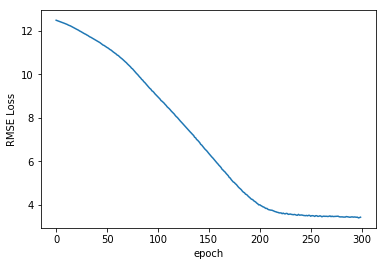

In [10]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch');

# Model Saving

The model weights were saved after training as a .pt file.

In [11]:
# Make sure to save the model only after the training has happened!
if len(losses) == epochs:
    torch.save(model.state_dict(), 'TaxiFareRegrModel.pt')
else:
    print('Model has not been trained. Consider loading a trained model instead.')

# Model Evaluation

The model was evaluated on the RMSE. It gave a quite a good RMSE.

In [12]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = gpumodel(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 3.71393895
